In [1]:
# Cell 1 – Imports & common paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox

ROOT      = Path("..").resolve()                         # repo root
FIG_DIR   = ROOT / "reports" / "plots" / "dl"
ARTF      = ROOT / "artifacts" / "forecasts"
METRIC    = ROOT / "artifacts" / "metrics"
FIG_DIR.mkdir(parents=True, exist_ok=True)
print("Figures will be saved to:", FIG_DIR)


Figures will be saved to: /teamspace/studios/this_studio/TS/AI_TimeSeries_Forecasting/reports/plots/dl


In [2]:
# Cell 2 – Load data
truth = pd.read_parquet("../data/processed/nasdaq_features.parquet")["log_ret"]
truth_test = truth.loc["2024-01-01":]

fc_lstm = pd.read_csv(ARTF / "lstm_test.csv", index_col=0, parse_dates=True).squeeze()

metrics_dl = pd.read_csv(METRIC / "dl_metrics.csv", index_col=None)
display(metrics_dl.set_index(pd.Index(["LSTM"])))


,MAE,RMSE,MAPE
LSTM,0.008275,0.011848,621714.746094


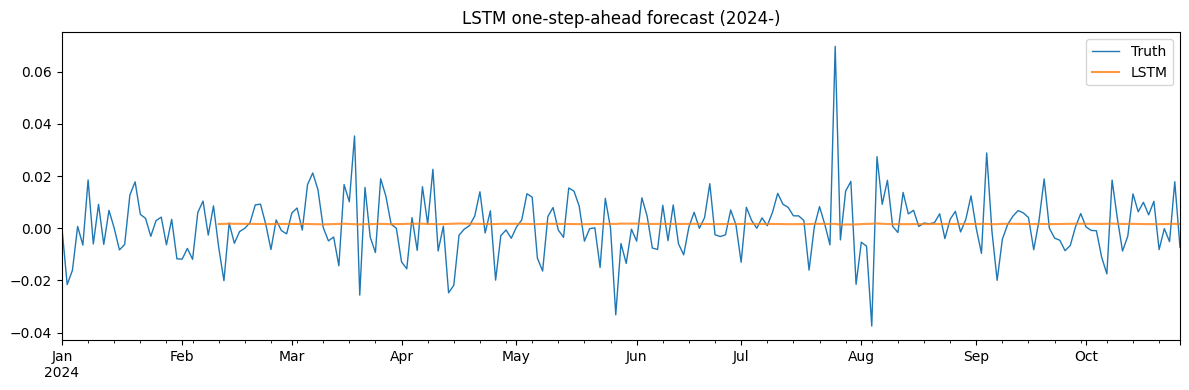

In [3]:
# Cell 3 – Overlay forecast
plt.figure(figsize=(12,4))
truth_test.plot(label="Truth", lw=1)
fc_lstm.plot(label="LSTM", alpha=0.8)
plt.title("LSTM one-step-ahead forecast (2024-)")
plt.legend()
plt.tight_layout()

plt.savefig(FIG_DIR / "lstm_forecast_overlay.png", dpi=300)
plt.show()


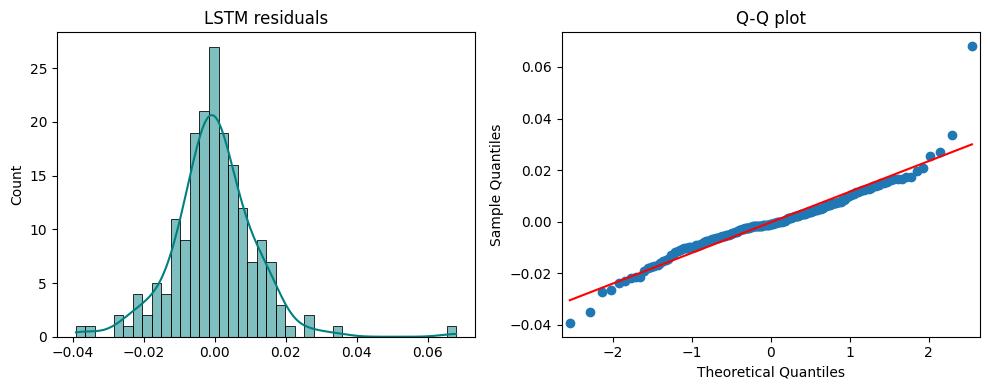

In [4]:
# Cell 4 – Residual diagnostics
res = truth_test.loc[fc_lstm.index] - fc_lstm

fig, ax = plt.subplots(1,2, figsize=(10,4))
sns.histplot(res, bins=40, kde=True, ax=ax[0], color="teal")
ax[0].set_title("LSTM residuals")

qqplot(res, line="s", ax=ax[1])
ax[1].set_title("Q-Q plot")

fig.tight_layout()
fig.savefig(FIG_DIR / "lstm_residuals.png", dpi=300)
plt.show()


Ljung-Box p-value (lag=10): 0.1492


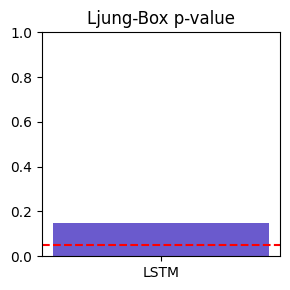

In [5]:
# Cell 5 – Autocorrelation check
lb = acorr_ljungbox(res, lags=[10], return_df=True)
pval = lb["lb_pvalue"].iloc[0]
print(f"Ljung-Box p-value (lag=10): {pval:.4f}")

plt.figure(figsize=(3,3))
plt.bar(["LSTM"], [pval], color="slateblue")
plt.axhline(0.05, ls="--", color="red")
plt.ylim(0,1)
plt.title("Ljung-Box p-value")
plt.tight_layout()

plt.savefig(FIG_DIR / "lstm_ljungbox.png", dpi=300)
plt.show()


In [6]:
# Cell 6 – Training curve (optional)
loss_csv = METRIC / "lstm_train_loss.csv"   # create this file in the future if desired
if loss_csv.exists():
    df_loss = pd.read_csv(loss_csv)
    plt.figure(figsize=(8,4))
    plt.plot(df_loss["epoch"], df_loss["train"], label="Train")
    plt.plot(df_loss["epoch"], df_loss["val"],   label="Val")
    plt.xlabel("Epoch"); plt.ylabel("MSE")
    plt.title("Training curve")
    plt.legend(); plt.tight_layout()
    plt.savefig(FIG_DIR / "lstm_training_curve.png", dpi=300)
    plt.show()
else:
    print("No training-loss CSV found – skipping curve plot.")


No training-loss CSV found – skipping curve plot.


In [7]:
# Cell 7 – Wrap-up
print("Deep-learning baseline evaluation complete.\n"
      "Plots in:", FIG_DIR, "\nMetrics in:", METRIC / "dl_metrics.csv")


Deep-learning baseline evaluation complete.
Plots in: /teamspace/studios/this_studio/TS/AI_TimeSeries_Forecasting/reports/plots/dl 
Metrics in: /teamspace/studios/this_studio/TS/AI_TimeSeries_Forecasting/artifacts/metrics/dl_metrics.csv
